### Подготовка данных.

Libraries

In [1]:
# for data
import os
import torch
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torchmetrics
from torchmetrics.functional import char_error_rate
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.nn.utils import clip_grad_norm_

# for training
import torch.nn as nn

Static configs

In [2]:
PATH_2_SAMPELS = 'samples/*'
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

BATCH_SIZE = 8

ALPHABETH = 'abcdefghijklmnopqrstuvwxyz'
DIGITS = '0123456789'
CHARS = ALPHABETH + DIGITS
VOCAB_SIZE = len(CHARS) + 1

EPOCHS = 50

In [3]:
class CaptchDataset(Dataset):
    """
    class for getting data and labels
    """
    def __init__(self, pth):
        """
        collect data
        """
        pth_list = os.listdir(pth)
        abs_pth = os.path.abspath(pth)
        print(abs_pth)
        self.imgs = [os.path.join(abs_pth, p) for p in pth_list]
        self.transform = transforms.Compose([
          transforms.ToTensor()  
        ])
    
    def __len__(self):
        """
        get length of the data
        """
        return len(self.imgs)
    
    def __getitem__(self, idx):
        """
        get tensor of the image and label by index
        """
        pth = self.imgs[idx]
        label = os.path.basename(pth).split('.')[0].lower().strip()
        img = Image.open(pth).convert('RGB')
        img_tensor = self.transform(img)
        return img_tensor, label
      

In [131]:

# prepare folders
os.system(f'mkdir data')
os.system(f"rm -rf data/train")
os.system(f"rm -rf data/test")
[os.system(f'mkdir data/{directory}') for directory in ('train', 'test')]


# split data for train and test 1/4
train_set, test_set = train_test_split(glob.glob(PATH_2_SAMPELS), test_size=0.2)
[os.system(f"cp {te} {TEST_DIR}/{te.split('/')[1]}") for te in test_set]
[os.system(f"cp {tr} {TRAIN_DIR}/{tr.split('/')[1]}") for tr in train_set]

train_dataset = CaptchDataset(TRAIN_DIR)
val_dataset = CaptchDataset(TEST_DIR)


# loading data
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False
)


mkdir: data: File exists


/Users/aleksandr/Desktop/captcha_recognition/data/train
/Users/aleksandr/Desktop/captcha_recognition/data/test


#### Создание и обучение модели.

CRNN class with layers

In [132]:
class CNNRNN(nn.Module):
    def __init__(self, vocab_size, dropout=0.5):
        """
        initiate layers
        """
        super(CNNRNN, self).__init__()
        # probability of an element to be zeroed (Bernoulli distribution)
        self.dropout = nn.Dropout(p=dropout)
        self.clayer = nn.Sequential(
            # With square kernels and equal stride and with padding
            nn.Conv2d(
                in_channels=3, # RGB
                out_channels=32, # quatity of kernels
                kernel_size=(3,3), # width of kernel
                stride=1, # step of kernel
                padding=1 # add for input image
            ),
            # activation max(0,x)
            nn.ReLU(), 
            nn.MaxPool2d(
                kernel_size=(2,2),
                stride=2
            ),
            # in_channels, out_channels, kernel_size
            nn.Conv2d(
                in_channels=32, # conv in layer t-1 out_channel
                out_channels=64,
                kernel_size=(3,3),
                stride=1, 
                padding=1),
            nn.ReLU(),
            # pool of square window of size=2, stride=2
            nn.MaxPool2d(
                kernel_size=(2,2), 
                stride=2
            ),
            
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(3,3), 
                stride=1, 
                padding=1
            ),
#             nn.BatchNorm2d(128),
            nn.ReLU(), # max(0,x)
            
            nn.Conv2d(
                in_channels=128,
                out_channels=256, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
            ),
#             nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(1,2), 
                stride=2
            ),
            
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(3,3), 
                stride=1, 
                padding=1,
#                 bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3,3), 
                stride=1, 
                padding=1,
#                 bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(1, 2), 
                stride=2),
            
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(2,2), 
                stride=1, 
                padding=0
            ),
            self.dropout
        )
        self.seq = nn.Sequential(
            nn.Linear(
                in_features=1024, 
                out_features=256
            ),
            self.dropout
        )
        # RNN to an input sequence
        self.rnn_layer = nn.LSTM(
            input_size=256,
            hidden_size=256, 
            num_layers=2, 
            bidirectional=True
        )
        # Linear transformation to the incoming data
        self.outlayer = nn.Linear(
            in_features=512, 
            out_features=vocab_size # quantity of classes
        )

        
    def forward(self, x):
        """
        method for CNN and RNN combining 
        """
        x = self.clayer(x) # CNN apply
        x = x.permute(0, 3, 1, 2) # transformate dimension [0, 1, 2, 3]->[0, 3, 1, 2]
        x = x.view(x.size(0), x.size(1), -1) # choose field
        x = self.seq(x) # apply linear with dropout
        x, _ = self.rnn_layer(x) # apply rnn layers
        x = self.outlayer(x) # apply linear layer
        return x.permute(1, 0, 2) # transformate dimension
        

In [133]:
class OCR:
    """
    module for training and validating
    """
    def __init__(self):
        """
        var inits
        """
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # choose device
        self.crnn = CNNRNN(VOCAB_SIZE).to(self.device) # init layers
        self.critertion = nn.CTCLoss() # The Connectionist Temporal Classification loss. 
        # Calculates loss between a continuous (unsegmented) time series and a target sequence. 
        self.char2idx, self.idx2char = self.char_idx()
        
        
    def char_idx(self):
        """
        function get dependence between chars and indexes
        """
        char2idx = {}
        idx2char = {}
        chars = CHARS.lower() + '-'
        for i, chara in enumerate(chars):
            char2idx[chara] = i + 1
            idx2char[i + 1] = chara
        return char2idx, idx2char
    
    def encode(self, labels):
        """
        function chars to code
        """
        length_per_label = [len(label) for label in labels]
        joined_label = ''.join(labels)
        joined_encoding = []
        for chara in joined_label:
            joined_encoding.append(self.char2idx[chara])
        return torch.IntTensor(joined_encoding), torch.IntTensor(length_per_label)
    
    def decode(self, logits):
        """
        function characters to code
        """
        tokens = logits.softmax(2).argmax(2).squeeze(1)
        tokens = ''.join([self.idx2char[token]
                         if token != 0 else '-'
                         for token in tokens.numpy()])
        tokens = tokens.split('-')
        
        text = [chara for batch_token in tokens \
               for idx, chara in enumerate(batch_token) \
               if chara != batch_token[idx-1] or len(batch_token) == 1]
        text = ''.join(text)
        return text
    
    def loss_func(self, logits, labels):
        """
        account CTCLoss loss
        """
        encoded_labels, labels_len = self.encode(labels) # tensor of labels in code and tensor of each length of label
        logits_lens = torch.full(
            size=(logits.size(1),),
            fill_value=logits.size(0),
            dtype=torch.int32
        ).to(self.device)
        
        return self.critertion(
            logits.log_softmax(2),
            encoded_labels,
            logits_lens,
            labels_len
        )
        
    def val_step(self, images, labels):
        """
        check validation score
        """
        logits = self.predict(images)
        loss = self.loss_func(logits, labels)
        return logits, loss
    
    def train_step(self, optimizer, images, labels):
        """
        central training loop and check training score
        """
        logits = self.predict(images) # get logits after predict
        optimizer.zero_grad() # no calc grads
        loss = self.loss_func(logits, labels) # get losses
        loss.backward() # backwrd pass
#         clip_grad_norm_(self.crnn.parameters(), max_norm=1)
        optimizer.step() # graidient move
        return logits, loss
    
    def predict(self, img):
        """
        predict logits by image
        """
        return self.crnn(img.to(self.device))
    
    def train(self, num_epochs, optimizer, train_loader, test_loader, print_every=2):
        """
        base training loop, get optimization metrics
        """
        train_losses, valid_losses = [], []
        for epoch in range(num_epochs):
            total_train_loss = 0
            self.crnn.train() # switch on train
            for i, (images, labels) in enumerate(train_loader):
                logits, train_loss = self.train_step(
                    optimizer,
                    images,
                    labels
                )
                total_train_loss += train_loss.item()
            
            with torch.no_grad():
                total_val_loss = 0
                self.crnn.eval()
                for i, (images, labels) in enumerate(test_loader):
                    logits, val_loss = self.val_step(images, labels)
                    total_val_loss += val_loss.item()
                train_loss = total_train_loss / len(train_loader.dataset)
                val_loss = total_val_loss / len(test_loader.dataset)
                train_losses.append(train_loss)
                valid_losses.append(val_loss)
            if epoch % print_every == 0:
                print(f'Epoch {epoch} | train loss {round(train_loss, 2)} | valid loss {round(val_loss, 2)}')
        return train_losses, valid_losses
        

In [134]:
ocr = OCR()
optimizer = optim.SGD(
            ocr.crnn.parameters(), 
            lr=0.021, 
            nesterov=True,
            weight_decay=1e-5,
            momentum=0.7
        )

train_losses, val_losses = ocr.train(
    EPOCHS,
    optimizer, 
    train_loader,
    val_loader
)

Epoch 0 | train loss 0.45 | valid loss 0.41
Epoch 2 | train loss 0.41 | valid loss 0.41
Epoch 4 | train loss 0.41 | valid loss 0.41
Epoch 6 | train loss 0.41 | valid loss 0.41
Epoch 8 | train loss 0.41 | valid loss 0.41
Epoch 10 | train loss 0.4 | valid loss 0.41
Epoch 12 | train loss 0.4 | valid loss 0.41
Epoch 14 | train loss 0.4 | valid loss 0.39
Epoch 16 | train loss 0.37 | valid loss 0.47
Epoch 18 | train loss 0.32 | valid loss 0.31
Epoch 20 | train loss 0.27 | valid loss 0.25
Epoch 22 | train loss 0.18 | valid loss 0.17
Epoch 24 | train loss 0.12 | valid loss 0.12
Epoch 26 | train loss 0.07 | valid loss 0.07
Epoch 28 | train loss 0.04 | valid loss 0.06
Epoch 30 | train loss 0.03 | valid loss 0.07
Epoch 32 | train loss 0.02 | valid loss 0.05
Epoch 34 | train loss 0.02 | valid loss 0.04
Epoch 36 | train loss 0.01 | valid loss 0.05
Epoch 38 | train loss 0.01 | valid loss 0.05
Epoch 40 | train loss 0.01 | valid loss 0.05
Epoch 42 | train loss 0.01 | valid loss 0.05
Epoch 44 | train l

### View results

In [148]:
class GetResult:
    def __init__(self, train_losses, val_losses):
        self.train_losses = train_losses
        self.val_losses = val_losses
    
    def plot_show(self, val_dataset):
        samples = []
        for i in range(10):
            with torch.no_grad():
                idx = np.random.randint(len(val_dataset))
                img, label = val_dataset[idx]
                logits = ocr.predict(img.unsqueeze(0))
                pred_text = ocr.decode(logits.cpu())

                samples.append((img, label, pred_text))

        fig = plt.figure(figsize=(17,5))
        for i in range(10):
            ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])

            img, label, pred_text = samples[i]
            title = f'True: {label} | Pred: {pred_text}'
            ax.imshow(img.permute(1,2,0))
            ax.set_title(title)

        plt.show()
        
    def plot_loss(self):
        plt.plot(self.train_losses, label='Train_loss')
        plt.plot(self.val_losses, label='Valid_loss')
        plt.title("Loss")
        plt.legend()
        plt.show()
        
    def get_prediction_results(self, df_):
        TRUE = []
        PRED = []
        with torch.no_grad():
            for i in range(len(df_)):
                img, label = df_[i]
                logits = ocr.predict(img.unsqueeze(0))
                pred = ocr.decode(logits.cpu())
                TRUE.append(label)
                PRED.append(pred)
        TRUE = pd.Series(TRUE, name='TRUE')
        PRED = pd.Series(PRED, name='PRED')
        df_res = pd.concat([TRUE,PRED], axis=1)
        cer = char_error_rate(df_res['TRUE'], df_res['PRED'])
        acc_sc = accuracy_score(df_res['TRUE'], df_res['PRED'])
        return f"Accuracy : {acc_sc}, Char Error Rate: {cer}"

    def plot_diff(self, val_dataset):
        samples = []
        for i in range(len(val_dataset)):
            with torch.no_grad():
                idx = np.random.randint(len(val_dataset))
                img, label = val_dataset[idx]
                logits = ocr.predict(img.unsqueeze(0))
                pred_text = ocr.decode(logits.cpu())
                if label != pred_text:
                    samples.append((img, label, pred_text))

        fig = plt.figure(figsize=(30,45))
        for i in range(len(samples)):
            

            img, label, pred_text = samples[i]
            
            if label != pred_text:
                ax = fig.add_subplot(21, 3, i + 1, xticks=[], yticks=[])
                title = f'True: {label} | Pred: {pred_text}'
                ax.imshow(img.permute(1,2,0))
                ax.set_title(title)

        plt.show()

plot examples of the predictions

In [149]:
gr = GetResult(train_losses, val_losses)
# gr.plot_show(val_dataset) 

plot loss

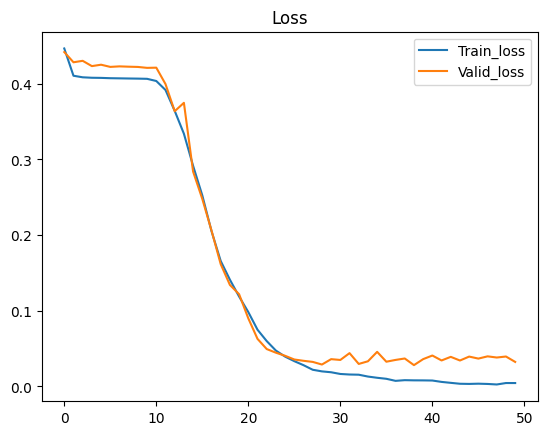

In [31]:
gr.plot_loss()

Scores

In [30]:
gr.get_prediction_results(val_dataset)

'Accuracy : 0.8598130841121495, Char Error Rate: 0.030188679695129395'

Анализ ошибок:

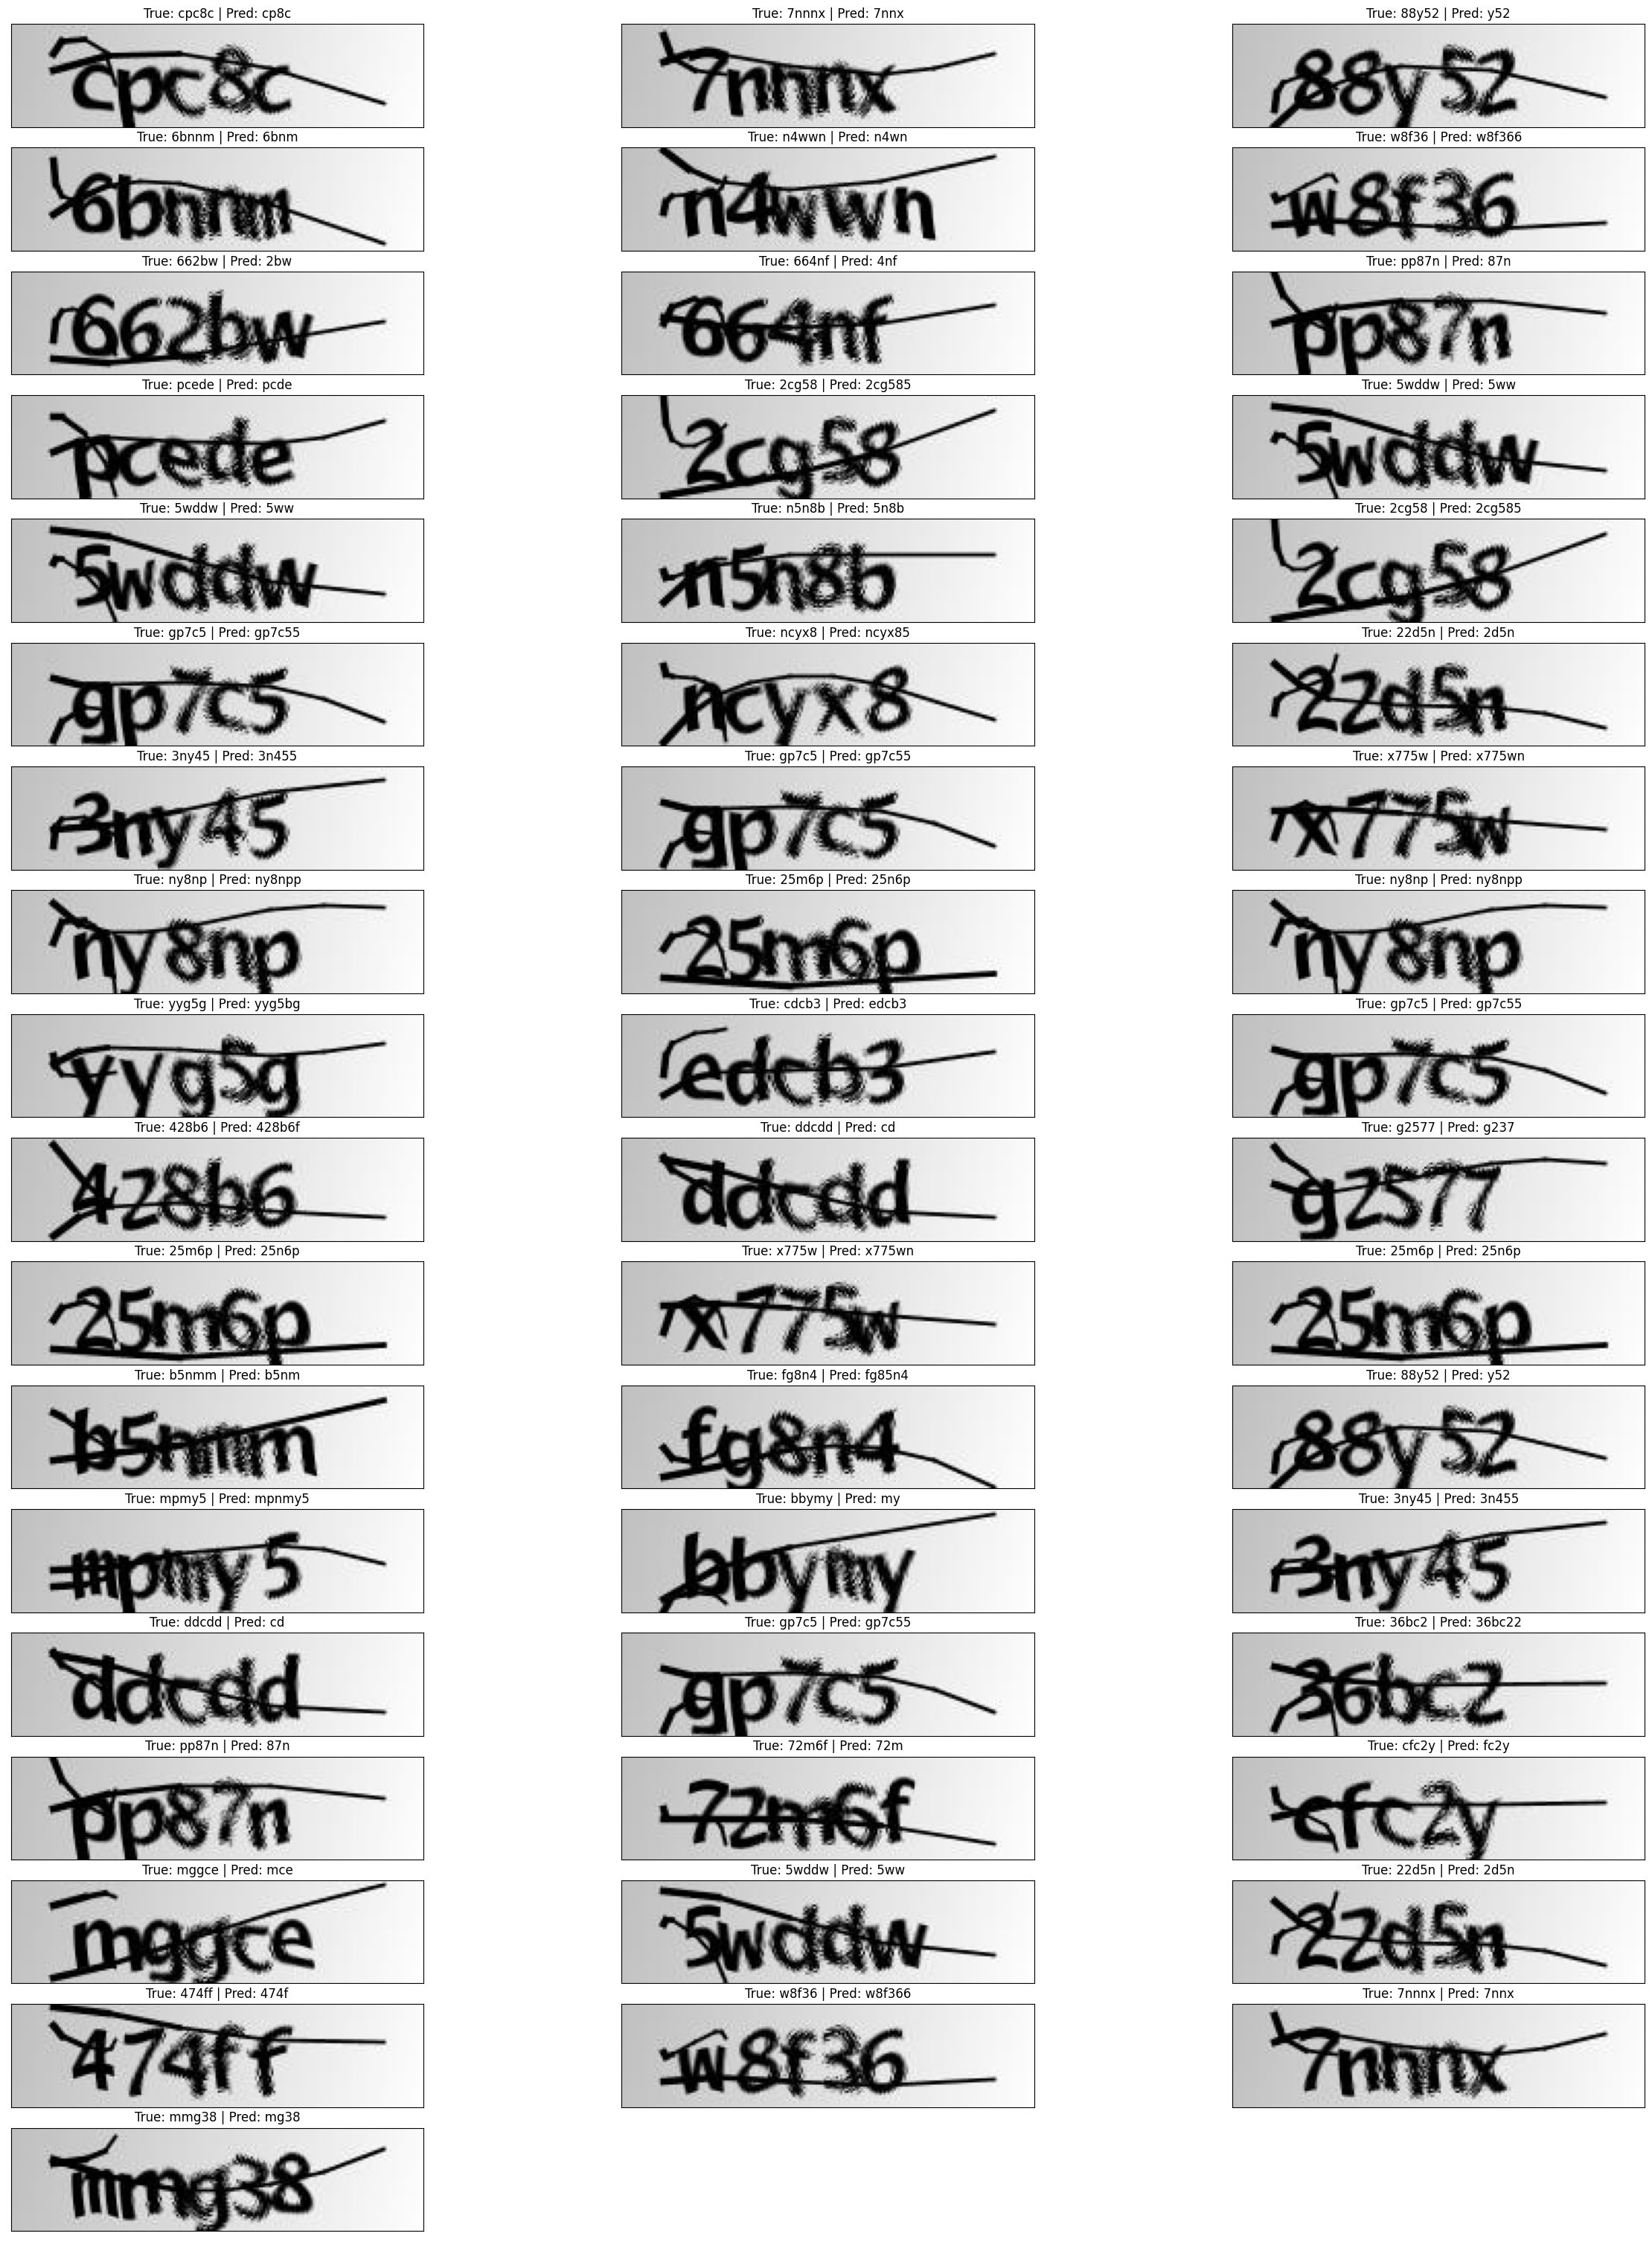

In [150]:
gr.plot_diff(val_dataset)

К валидным результатам пришел со скором 0.54 accuracy и Char Error Rate 0.22. Дальше начал перебирать параметры и слои 
число эпох, оптимизатор, RRN классификатор, learning rate, размерности слоев, добавлял/убирал нормализацию,
свобдный член bias, клипал градиенты.
В итоге удалось достичь с помощью статьи https://arxiv.org/pdf/1507.05717.pdf 
Accuracy : 86%, Char Error Rate (доля неверно распознанных символов) : 3%

Видно, что большиство ошибок связано с крайними сиволами. 
Это либо начало, либо конец капчи. 
Для того, чтобы уменьшить мисклассификацию по чарам в крайних значениях нужно 
дополнительные данные + можно дообучить на готовых датасетах.  Также мы можем аугументировать данные. Больше примеров дают меньшую ошибку по показателю CER
